In [1]:
import numpy as np, pandas as pd
from glob import glob
import shutil, os
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupKFold
from tqdm.notebook import tqdm
import seaborn as sns

In [2]:
dim = 512 
test_dir = f'/kaggle/input/vinbigdata-{dim}-image-dataset/vinbigdata/test'
weights_dir = '/kaggle/input/10percent-train-as-test-512images/yolov5/runs/train/exp/weights/best.pt'

In [3]:
test_df = pd.read_csv(f'/kaggle/input/vinbigdata-{dim}-image-dataset/vinbigdata/test.csv')
test_df.head()

image_id  width  height
0  83caa8a85e03606cf57e49147d7ac569   2304    2880
1  7550347fa2bb96c2354a3716dfa3a69c   2538    3095
2  74b23792db329cff5843e36efb8aa65a   2788    3120
3  94568a546be103177cb582d3e91cd2d8   1994    2430
4  6da36354fc904b63bc03eb3884e0c35c   2056    2376

# YOLOv5

In [4]:
shutil.copytree('/kaggle/input/yolov5-official-v31-dataset/yolov5', '/kaggle/working/yolov5')
os.chdir('/kaggle/working/yolov5') # install dependencies

import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.7.0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', major=6, minor=0, total_memory=16280MB, multi_processor_count=56)


# Inference

In [5]:
!python detect.py --weights $weights_dir\
--img 640\
--conf 0.01\
--iou 0.4\
--source $test_dir\
--save-txt --save-conf --exist-ok

Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.01, device='', exist_ok=True, img_size=640, iou_thres=0.4, name='exp', project='runs/detect', save_conf=True, save_txt=True, source='/kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test', update=False, view_img=False, weights=['/kaggle/input/10percent-train-as-test-512images/yolov5/runs/train/exp/weights/best.pt'])
Fusing layers... 
image 1/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/002a34c58c5b758217ed1f584ccbcfe9.png: 640x640 1 Aortic enlargements, 1 Cardiomegalys, 5 Pleural thickenings, Done. (0.057s)
image 2/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/004f33259ee4aef671c2b95d54e4be68.png: 640x640 2 Aortic enlargements, 1 Cardiomegalys, 1 Pleural thickenings, Done. (0.050s)
image 3/3000 /kaggle/input/vinbigdata-512-image-dataset/vinbigdata/test/008bdde2af2462e86fd373a445d0f4cd.png: 640x640 1 Aortic enlargements, 1 Cardiomegalys, 1 Nodule/Masss, 1 Pleural thickenings

# Inference Plot

100%|██████████| 16/16 [00:00<00:00, 125.44it/s]


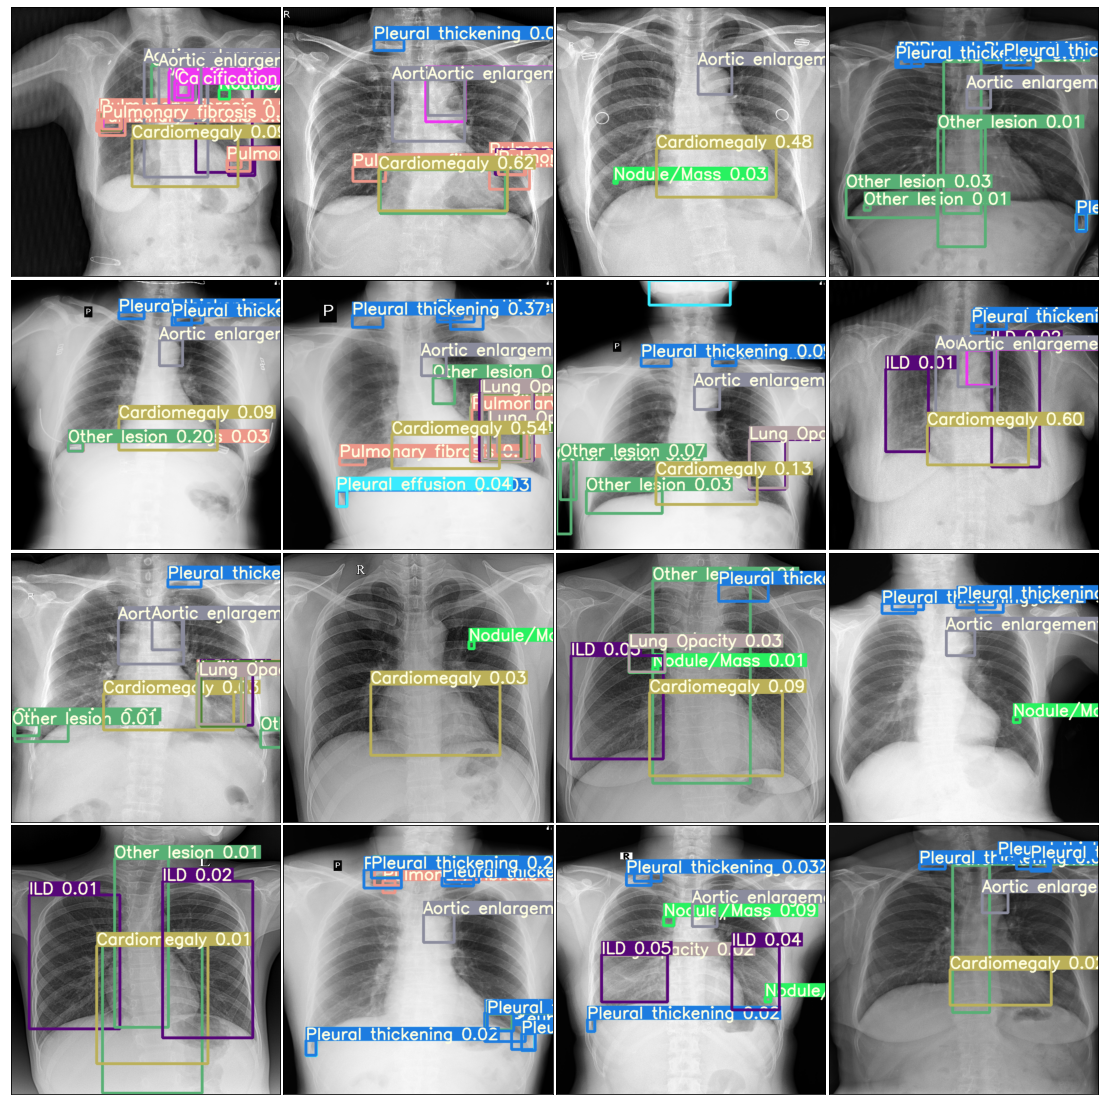

100%|██████████| 16/16 [00:00<00:00, 129.19it/s]


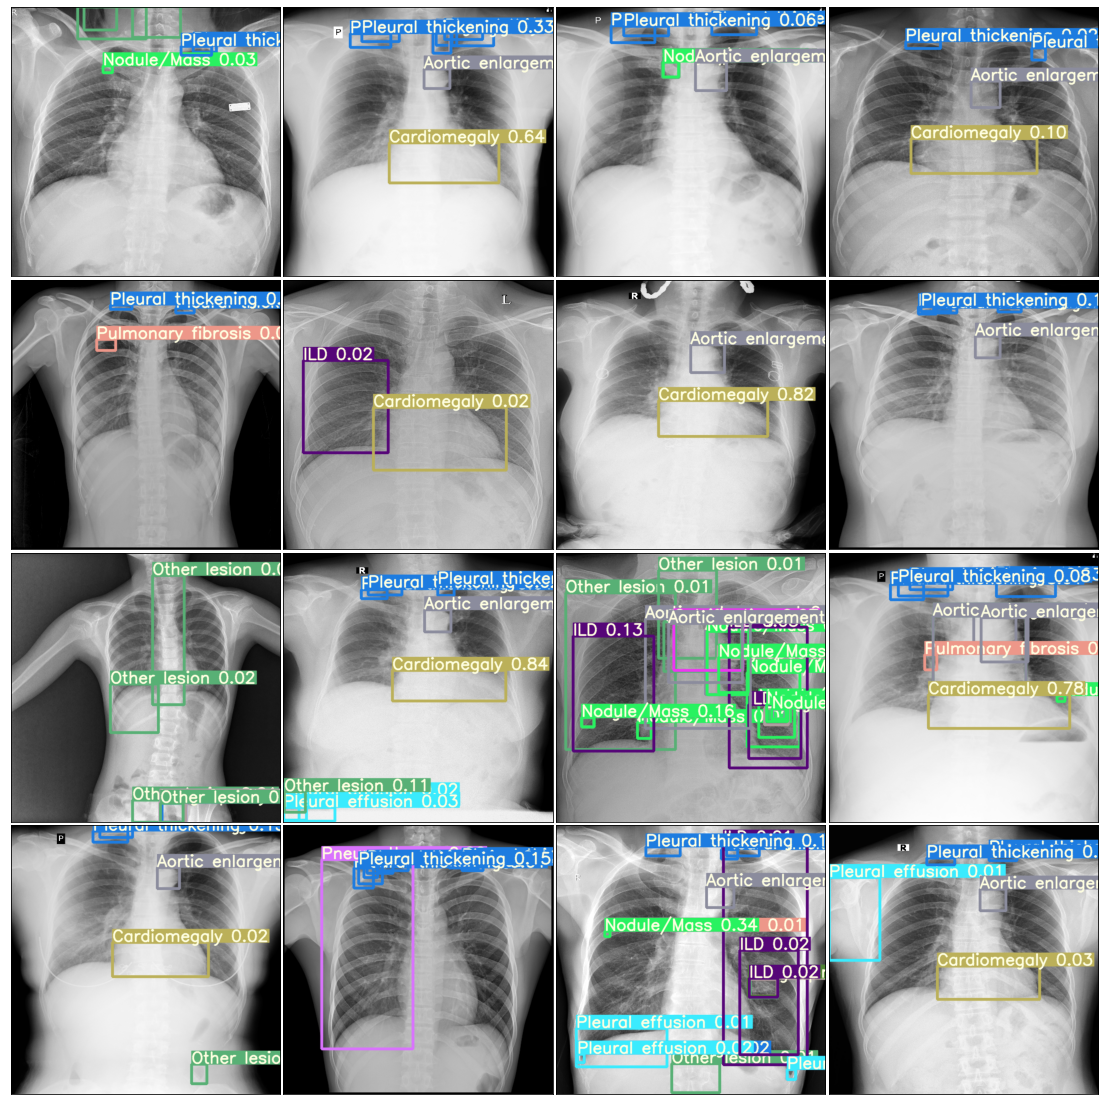

100%|██████████| 16/16 [00:00<00:00, 87.59it/s]


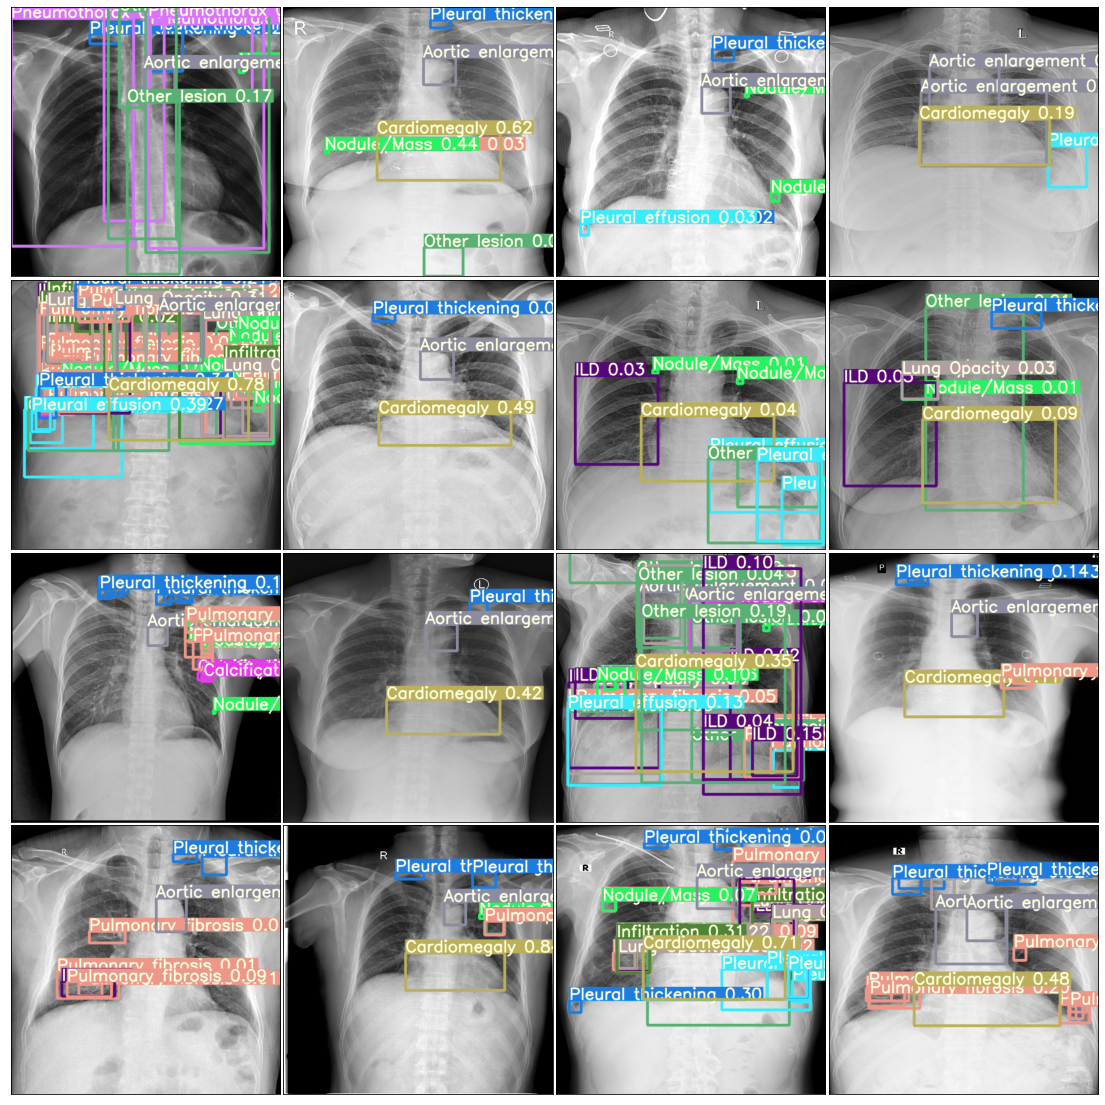

In [6]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random
import cv2
from glob import glob
from tqdm import tqdm

files = glob('runs/detect/exp/*png')
for _ in range(3):
    row = 4
    col = 4
    grid_files = random.sample(files, row*col)
    images     = []
    for image_path in tqdm(grid_files):
        img          = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        images.append(img)

    fig = plt.figure(figsize=(col*5, row*5))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(col, row),  # creates 2x2 grid of axes
                     axes_pad=0.05,  # pad between axes in inch.
                     )

    for ax, im in zip(grid, images):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

# Process Submission

In [7]:

def yolo2voc(image_height, image_width, bboxes):
    """
    yolo => [xmid, ymid, w, h] (normalized)
    voc  => [x1, y1, x2, y1]
    
    """ 
    bboxes = bboxes.copy().astype(float) # otherwise all value will be 0 as voc_pascal dtype is np.int
    
    bboxes[..., [0, 2]] = bboxes[..., [0, 2]]* image_width
    bboxes[..., [1, 3]] = bboxes[..., [1, 3]]* image_height
    
    bboxes[..., [0, 1]] = bboxes[..., [0, 1]] - bboxes[..., [2, 3]]/2
    bboxes[..., [2, 3]] = bboxes[..., [0, 1]] + bboxes[..., [2, 3]]
    
    return bboxes


In [8]:
image_ids = []
PredictionStrings = []

for file_path in tqdm(glob('runs/detect/exp/labels/*txt')):
    image_id = file_path.split('/')[-1].split('.')[0]
    w, h = test_df.loc[test_df.image_id==image_id,['width', 'height']].values[0]
    f = open(file_path, 'r')
    data = np.array(f.read().replace('\n', ' ').strip().split(' ')).astype(np.float32).reshape(-1, 6)
    data = data[:, [0, 5, 1, 2, 3, 4]]
    bboxes = list(np.round(np.concatenate((data[:, :2], np.round(yolo2voc(h, w, data[:, 2:]))), axis =1).reshape(-1), 1).astype(str))
    for idx in range(len(bboxes)):
        bboxes[idx] = str(int(float(bboxes[idx]))) if idx%6!=1 else bboxes[idx]
    image_ids.append(image_id)
    PredictionStrings.append(' '.join(bboxes))

100%|██████████| 2990/2990 [00:05<00:00, 541.88it/s]


In [9]:
pred_df = pd.DataFrame({'image_id':image_ids,
                        'PredictionString':PredictionStrings})
sub_df = pd.merge(test_df, pred_df, on = 'image_id', how = 'left').fillna("14 1 0 0 1 1")
sub_df = sub_df[['image_id', 'PredictionString']]
sub_df.to_csv('/kaggle/working/submission.csv',index = False)
sub_df.tail()

image_id  \
2995  7f5503caa936a623b4388fbd88e890c5   
2996  c97e54a78bab9c05ce2e04fe6c284bcd   
2997  33218cf183c1224a74ccfb514e827e15   
2998  04b700c4815f088728db9f093c739707   
2999  14da9051525bd2504dd56938f92644ef   

                                       PredictionString  
2995  11 0.0 753 440 1063 502 8 0.0 1868 768 1930 82...  
2996  11 0.0 1110 588 1512 672 11 0.2 1866 588 2226 ...  
2997  11 0.0 1579 421 1834 548 7 0.0 917 1152 1104 1...  
2998  13 0.0 291 1622 359 1735 8 0.0 1853 2304 1882 ...  
2999  8 0.0 382 869 448 925 11 0.0 565 517 728 565 1...

In [10]:
shutil.rmtree('/kaggle/working/yolov5')

In [11]:
%cd /kaggle/working

from IPython.display import FileLink 
FileLink(r'submission.csv')

/kaggle/working


/kaggle/working/submission.csv